<a href="https://colab.research.google.com/github/bberfin/Alzheimer-Disease-Prediction/blob/main/date29_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
#IMPORT / VIEWING / PREPROCESSING DATASET

In [4]:
#DATA AUGMENTATION

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/AugmentedAlzheimerDataset',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 1600 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/AugmentedAlzheimerDataset',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 400 images belonging to 4 classes.


100%|██████████| 5/5 [01:34<00:00, 18.99s/it]


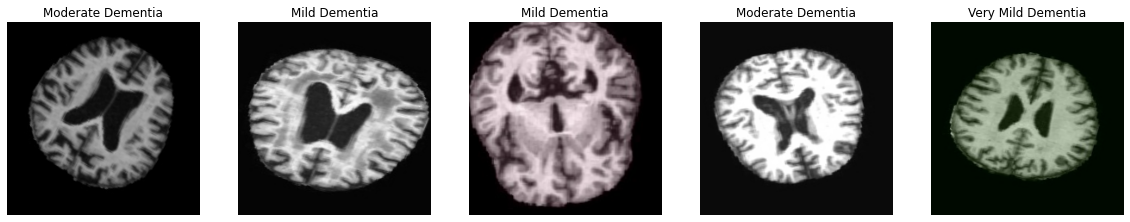

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [9]:
#MODEL BUILDING

In [10]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 0s 0us/step


In [11]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [12]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [13]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [14]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [16]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.7292 - auc: 0.6662 
Epoch 1: val_auc improved from -inf to 0.65447, saving model to ./best_weights.hdf5
13/13 [==============================] - 526s 38s/step - loss: 1.7292 - auc: 0.6662 - val_loss: 5.7406 - val_auc: 0.6545
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.2750 - auc: 0.7775 
Epoch 2: val_auc improved from 0.65447 to 0.72390, saving model to ./best_weights.hdf5
13/13 [==============================] - 455s 35s/step - loss: 1.2750 - auc: 0.7775 - val_loss: 3.5111 - val_auc: 0.7239
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1356 - auc: 0.8150 
Epoch 3: val_auc improved from 0.72390 to 0.79277, saving model to ./best_weights.hdf5
13/13 [==============================] - 452s 35s/step - loss: 1.1356 - auc: 0.8150 - val_loss: 2.1073 - val_auc: 0.7928
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.9990 - auc: 0.8492 
Epoch 4: val_auc im

In [17]:
#MODEL EVALUATION

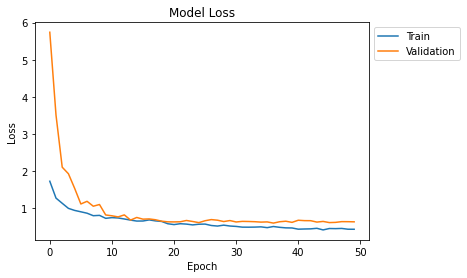

In [18]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

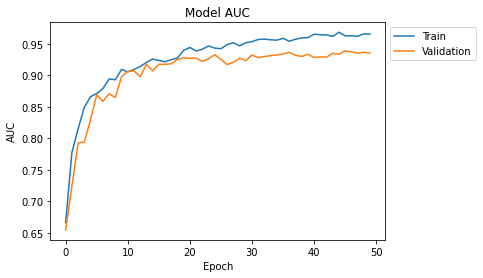

In [19]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/OriginalDataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 3514 images belonging to 4 classes.


In [21]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

28/28 [==============================] - 661s 24s/step - loss: 0.8048 - auc: 0.9023


[0.8048031330108643, 0.902341902256012]

1/1 [==============================] - 0s 374ms/step
97.21 % chances are there that the image is NonDemented


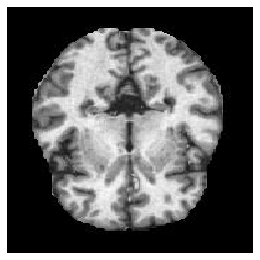

In [30]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/OriginalDataset/NonDemented/nonDem283.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 1s 588ms/step
73.07 % chances are there that the image is MildDemented


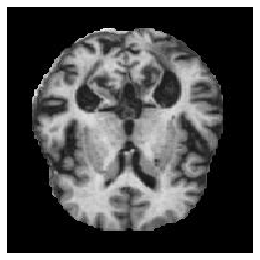

In [31]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/OriginalDataset/MildDemented/mildDem171.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 380ms/step
99.99 % chances are there that the image is ModerateDemented


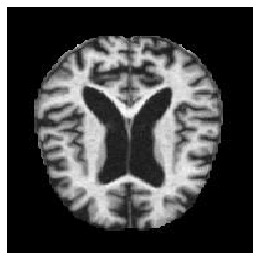

In [33]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/OriginalDataset/ModerateDemented/moderateDem44.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 379ms/step
57.25 % chances are there that the image is VeryMildDemented


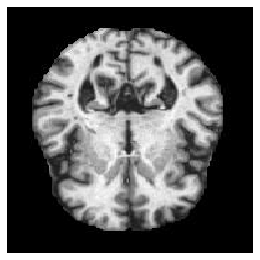

In [34]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/OriginalDataset/VeryMildDemented/verymildDem307.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 373ms/step
99.4 % chances are there that the image is VeryMildDemented


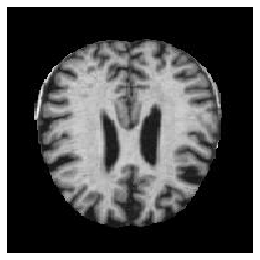

In [35]:
# Test Case 5: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/OriginalDataset/VeryMildDemented/32 (43).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

In [36]:
#Conclusion:

#So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.